# 4. TÉCNICAS DE EXPLORACIÓN Y REDUCCIÓN DE DATOS



1. Análisis de Componentes Principales (PCA)
2. Análisis Factorial (FA)

Cada sección incluye: formulación matemática, propiedades, criterios de selección de dimensión, algoritmos computacionales (SVD / eigen), ilustraciones numéricas y ejemplos en Python. Las fórmulas se muestran con LaTeX para renderizado en Jupyter/Colab.

-----

## 1. ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

### 1.1 Objetivo y formulación matemática

Dado un conjunto de datos centrado (media cero) representado por la matriz \(X\in\mathbb{R}^{n\times p}\) (filas = observaciones, columnas = variables), PCA busca vectores unitarios \(w\in\mathbb{R}^p\) que maximizan la varianza proyectada:

$$\max_{w:\,\|w\|=1} \; \mathrm{Var}(Xw) = w^T S w$$

donde \(S=\frac{1}{n-1}X^T X\) es la matriz de covarianza muestral. La solución es el problema de autovalores:

$$S w_i = \lambda_i w_i, \quad \lambda_1\ge\lambda_2\ge\dots\ge\lambda_p\ge 0.$$ 

El vector \(w_i\) (autovector) es el i-ésimo componente principal y \(\lambda_i\) la varianza explicada por ese componente.

La proyección de los datos en los primeros \(k\) componentes se escribe:

$$Z = X W_k, \quad W_k = [w_1,\dots,w_k] \in\mathbb{R}^{p\times k}.$$

### 1.2 Relación con SVD (singular value decomposition)

Sea la SVD de la matriz centrada \(X=U \Sigma V^T\). Entonces:

- Las columnas de \(V\) son autovectores de \(X^T X\) (proporcionales a \(w_i\)).
- Las singular values al cuadrado (divididas por \(n-1\)) son los autovalores \(\lambda_i\).

Más explícito:

$$X^T X = V \Sigma^2 V^T, \quad S = \frac{1}{n-1} X^T X = V \left(\frac{\Sigma^2}{n-1}\right) V^T.$$

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

np.random.seed(0)
# Simulamos datos correlacionados (ejemplo académico)
n, p = 150, 5
L = np.array([[1.0, 0.8, 0.6, 0.0, 0.0],
              [0.0, 0.2, 0.1, 0.9, 0.7]])
factors = np.random.normal(size=(n, 2))
noise = np.random.normal(scale=0.5, size=(n, p))
X = factors.dot(L) + noise
df = pd.DataFrame(X, columns=[f'V{i+1}' for i in range(p)])
df.head()

,V1,V2,V3,V4,V5
0,1.110789,2.320339,1.039365,0.020052,0.613302
1,0.748378,0.564040,0.137973,2.363690,1.488839
2,1.800707,1.837463,0.459394,-1.244889,-0.876534
3,0.997264,0.708714,0.411474,-0.167035,-0.159603
4,-0.463021,-0.406952,0.116387,-0.075919,-0.291259


### 1.3 Cálculo práctico: SVD vs eigen decomposition

Mostraremos cómo obtener componentes por SVD y por la matriz de covarianza, y verificaremos equivalencia numérica.

In [16]:
# Centrar y estandarizar (PCA suele realizarse sobre datos centrados; aquí usamos estandarización)
scaler = StandardScaler(with_mean=True, with_std=True)
Xs = scaler.fit_transform(df)

# SVD
U, s, Vt = np.linalg.svd(Xs, full_matrices=False)
singular_values = s

# Autovalores a partir de SVD
eigen_from_svd = (s**2) / (n - 1)

# Matriz de covarianza y eigen decomposition
S = np.cov(Xs, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(S)
# ordenar de mayor a menor
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print('Autovalores (SVD->eigen):', np.round(eigen_from_svd[:5],4))
print('Autovalores (cov matrix):', np.round(eigvals[:5],4))

print('\nPrimer autovector (SVD, Vt[0]):\n', np.round(Vt[0,:],4))
print('\nPrimer autovector (from eigvecs)\n', np.round(eigvecs[:,0],4))

Autovalores (SVD->eigen): [2.4509 1.7278 0.363  0.2804 0.2115]
Autovalores (cov matrix): [2.4509 1.7278 0.363  0.2804 0.2115]

Primer autovector (SVD, Vt[0]):
 [-0.578  -0.5851 -0.5532 -0.0735 -0.1104]

Primer autovector (from eigvecs)
 [-0.578  -0.5851 -0.5532 -0.0735 -0.1104]


### 1.4 Varianza explicada y criterios de selección de dimensión

Definimos la varianza explicada por cada componente:

$$\text{Varianza explicada (ratio)}_i = \frac{\lambda_i}{\sum_{j=1}^p \lambda_j}.$$

Criterios comunes para elegir \(k\):

- Regla de Kaiser: conservar componentes con \(\lambda_i>1\) (si se trabaja con correlación y variables estandarizadas).
- Varianza acumulada: elegir el menor \(k\) tal que la varianza acumulada sea ≥ 80%–95%.
- Gráfica de "scree" (codo) — seleccionar el punto donde la pendiente decrece bruscamente.
- Análisis paralelo (parallel analysis) — comparar autovalores con autovalores de datos aleatorios.

Varianza explicada por componente: [0.4869 0.3432 0.0721 0.0557 0.042 ]
Varianza acumulada: [0.4869 0.8302 0.9023 0.958  1.    ]


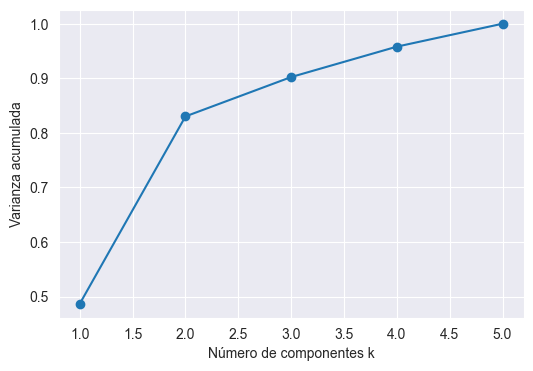

In [17]:
# PCA con scikit-learn para obtener varianza explicada
pca = PCA()
pca.fit(Xs)
explained_ratio = pca.explained_variance_ratio_
cumvar = np.cumsum(explained_ratio)

print('Varianza explicada por componente:', np.round(explained_ratio,4))
print('Varianza acumulada:', np.round(cumvar,4))

plt.figure(figsize=(6,4))
plt.plot(range(1, p+1), cumvar, marker='o')
plt.xlabel('Número de componentes k')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

### 1.5 Reconstrucción y error de reconstrucción

Si seleccionamos \(k\) componentes y la matriz de proyección \(W_k\), la reconstrucción de la matriz centrada es

$$\widehat{X} = Z W_k^T = X W_k W_k^T.$$ 

El error de reconstrucción (sum of squared reconstruction error) viene dado por la suma de autovalores no retenidos:

$$\sum_{i=k+1}^p \lambda_i = \text{tr}(S) - \sum_{i=1}^k \lambda_i.$$

In [18]:
k = 2
Wk = pca.components_[:k].T  # columnas son vectores propios correspondientes a PC1..PCk
Z = Xs.dot(Wk)
X_hat = Z.dot(Wk.T)
reconstruction_error = np.sum((Xs - X_hat)**2)
sum_unretained = np.sum(np.linalg.eigvalsh(S)[0:p][k:])
print('Error de reconstrucción (SSE):', round(reconstruction_error,4))
print('Suma de autovalores no retenidos:', round(sum_unretained,4))

Error de reconstrucción (SSE): 127.3821
Suma de autovalores no retenidos: 4.5417


### 1.6 Interpretación de cargas (loadings)

Las cargas del PCA son las entradas de los autovectores (o filas de \(W_k\) si se normalizan apropiadamente). Indican la contribución de cada variable original al componente principal. Para interpretación práctica se suele observar la magnitud y signo de estas cargas.

In [19]:
loadings = pd.DataFrame(Wk, index=df.columns, columns=[f'PC{i+1}' for i in range(k)])
loadings

,PC1,PC2
V1,0.577953,-0.137827
V2,0.585110,-0.014294
V3,0.553213,-0.072672
V4,0.073453,0.702255
V5,0.110351,0.694519


## 2. ANÁLISIS FACTORIAL (FA) — Tratamiento matemático

### 2.1 Planteamiento del modelo factorial

El modelo factorial con \(m\) factores supone que la variable observada vectorial \(x\in\mathbb{R}^p\) (centrada) se escribe como:

$$
x = A f + \varepsilon
$$

donde:

- $A \in \mathbb{R}^{p\times m}$ es la matriz de cargas factoriales (loadings).
- $f \in \mathbb{R}^m$ es el vector de factores comunes (aleatorios), típicamente con
  $$
  \mathbb{E}[f]=0,\qquad
  \mathrm{Cov}(f)=
  \begin{cases}
    I_m & \text{(identidad / factores ortogonales)},\\[4pt]
    \Phi & \text{(si los factores están correlacionados)}.
  \end{cases}
  $$
- \(\varepsilon \in \mathbb{R}^p\) es el vector de errores específicos, con
  $$
  \mathbb{E}[\varepsilon]=0,\qquad \mathrm{Cov}(\varepsilon)=\Psi,
  $$
  donde \(\Psi\) se asume diagonal. Además se supone \(\mathrm{Cov}(f,\varepsilon)=0\).

Entonces la matriz de covarianza poblacional queda:

$$
\Sigma = A\,\mathrm{Cov}(f)\,A^{T} + \Psi.
$$

En la normalización común \(\mathrm{Cov}(f)=I_m\):

$$
\Sigma = A A^{T} + \Psi.
$$


### 2.2 Identificabilidad y número de parámetros

El modelo no es identificable sin restricciones porque para cualquier matriz ortogonal \(Q\in\mathbb{R}^{m\times m}\) se tiene \(A f = (A Q)(Q^T f)\). Se impone usualmente que \(\mathrm{Cov}(f)=I\) y/o se fijan restricciones en \(A\) (por ejemplo, estructura superior triangular) para lograr identificabilidad.

Número de parámetros aproximado a estimar (sin restricciones):

$$\text{parámetros} = pm + p - \frac{m(m-1)}{2}$$

porque la matriz \(\Psi\) es diagonal (p parámetros) y \(A\) tiene \(pm\) entradas, pero hay \(\frac{m(m-1)}{2}\) parámetros no identificables por rotaciones ortogonales.

### 2.3 Métodos de estimación

Métodos comunes para estimar \(A\) y \(\Psi\):

- **Máxima verosimilitud (ML)**: asume normalidad multivariante y maximiza la función de verosimilitud de la muestra respecto a \(A\) y \(\Psi\).
- **Análisis de ejes principales (Principal Axis Factoring)**: se basa en la matriz de correlaciones ajustada y estima comunalidades iterativamente.
- **Método de mínimos cuadrados** sobre la matriz de correlaciones.

Para ML se maximiza (simplificado) la log-verosimilitud:

$$\ell(A,\Psi) = -\frac{n}{2}\left( \log|\Sigma| + \mathrm{tr}(S \Sigma^{-1}) \right) + \text{constante},$$

donde \(S\) es la matriz de covarianza muestral. La optimización se realiza numéricamente (algoritmos EM o Newton-Raphson en software estadístico).

In [20]:
from sklearn.decomposition import FactorAnalysis

# Ajuste de Análisis Factorial (m = 2 factores)
m = 2
fa = FactorAnalysis(n_components=m, random_state=0)
F = fa.fit_transform(Xs)  # scores de factores
A_est = pd.DataFrame(fa.components_.T, index=df.columns, columns=[f'F{i+1}' for i in range(m)])
psi_est = fa.noise_variance_

print('Cargas factoriales estimadas (A):')
display(A_est)
print('\nVarianzas específicas estimadas (Psi):')
print(np.round(psi_est,4))

Cargas factoriales estimadas (A):


,F1,F2
V1,-0.886744,0.130079
V2,-0.880192,-0.026597
V3,-0.762910,0.040306
V4,-0.063749,-0.847817
V5,-0.122410,-0.835982



Varianzas específicas estimadas (Psi):
[0.1979 0.2241 0.416  0.2781 0.2859]


### 2.4 Comunalidades y especificidades

La comunalidad estimada de la variable \(j\) es:

$$h_j^2 = \sum_{i=1}^m a_{ji}^2$$

y la especificidad (varianza única) se aproxima por \(\psi_j\). La suma total de comunalidades indica cuánta parte de la varianza total del conjunto de variables es explicada por los factores comunes.

In [21]:
communalities = np.sum(A_est.values**2, axis=1)
df_comm = pd.DataFrame({'Comunalidad': communalities, 'Especificidad(Psi)': psi_est}, index=df.columns)
df_comm

,Comunalidad,Especificidad(Psi)
V1,0.803236,0.197896
V2,0.775445,0.224109
V3,0.583656,0.415958
V4,0.722857,0.278079
V5,0.713850,0.285867


### 2.5 Rotaciones y interpretabilidad

La estimación inicial de cargas puede no ser única ni interpretativamente clara. Las rotaciones buscan una estructura más simple (simple structure).

Rotaciones ortogonales (ej. Varimax) mantienen factores no correlacionados; las rotaciones oblicuas (ej. Promax) permiten factores correlacionados.

Varimax maximiza la varianza de los cuadrados de las cargas por factor, formalmente se optimiza:

$$\max_Q \sum_{j=1}^m \left[ \frac{1}{p} \sum_{k=1}^p (a_{kj}^2)^2 - \left(\frac{1}{p}\sum_{k=1}^p a_{kj}^2\right)^2 \right],$$

donde \(A Q\) son las cargas rotadas por una matriz ortogonal \(Q\).

A continuación implementamos una función simple de rotación Varimax (algoritmo clásico) y aplicamos la rotación a las cargas estimadas.

In [22]:
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    """
    Varimax rotation (Kaiser) for loadings matrix Phi (p x m).
    Returns (rotated_loadings, rotation_matrix).
    """
    Phi = np.asarray(Phi, dtype=float)
    p, m = Phi.shape
    R = np.eye(m)
    d = 0.0
    for _ in range(q):
        L = Phi @ R                           # (p x m)
        # elementwise product: L * (L^2 - (gamma/p) * col_sums)
        col_sq_sum = np.sum(L**2, axis=0)     # (m,)
        tmp = L * (L**2 - (gamma / p) * col_sq_sum)
        # SVD on (m x m) matrix
        u, s, vh = np.linalg.svd(Phi.T @ tmp)
        R = u @ vh
        d_new = np.sum(s)
        if d_new - d < tol:
            break
        d = d_new
    return Phi @ R, R

# Apply Varimax to the estimated loadings
Phi = A_est.values
Phi_rot, R = varimax(Phi)
A_rot = pd.DataFrame(Phi_rot, index=df.columns, columns=A_est.columns)
A_rot


,F1,F2
V1,-0.892852,0.077789
V2,-0.877112,-0.078233
V3,-0.763960,-0.004559
V4,-0.013858,-0.850097
V5,-0.073113,-0.841727


### 2.6 Validaciones y pruebas complementarias

Antes de aplicar FA en datos reales, es usual evaluar la adecuación de los datos:

- **Kaiser-Meyer-Olkin (KMO)**: mide la adecuación de la muestra para FA (valores cercanos a 1 indican adecuación).
- **Prueba de esfericidad de Bartlett**: prueba la hipótesis nula de que la matriz de correlación es identidad (si se rechaza, hay correlaciones significativas y FA puede ser apropiado).

Implementaciones específicas de KMO/Bartlett están disponibles en paquetes estadísticos; aquí mencionamos su propósito académico.

-----

## 3. EJEMPLO COMPLETO Y DISCUSIÓN

Usaremos los pasos siguientes en un flujo típico académico:
1. Estandarizar los datos.
2. Ejecutar PCA para exploración y decidir un número preliminar de factores/componentes.
3. Ejecutar FA (ML o método iterativo), estimar cargas, comunalidades y varianzas específicas.
4. Aplicar rotación para mejorar interpretabilidad.
5. Evaluar ajuste y reportar resultados (comunalidades, proporción de varianza explicada por factores).

A continuación reunimos en un bloque limpio el flujo completo (resumen computacional).

In [23]:
def pca_and_fa_pipeline(X_raw, n_factors=2, scale=True):
    # X_raw: DataFrame o array
    X = np.array(X_raw)
    if scale:
        Xs = StandardScaler().fit_transform(X)
    else:
        Xs = X - X.mean(axis=0)
    # PCA exploration
    pca = PCA()
    pca.fit(Xs)
    evr = pca.explained_variance_ratio_
    cumvar = np.cumsum(evr)
    # FA
    fa = FactorAnalysis(n_components=n_factors)
    scores = fa.fit_transform(Xs)
    A = pd.DataFrame(fa.components_.T, index=[f'V{i+1}' for i in range(Xs.shape[1])], columns=[f'F{i+1}' for i in range(n_factors)])
    psi = fa.noise_variance_
    communalities = np.sum(A.values**2, axis=1)
    # rotated
    A_rot, R = varimax(A.values)
    A_rot = pd.DataFrame(A_rot, index=A.index, columns=A.columns)
    return { 'pca_evr': evr, 'pca_cumvar': cumvar, 'A': A, 'psi': psi, 'communalities': communalities, 'A_rot': A_rot, 'scores': scores }

results = pca_and_fa_pipeline(df, n_factors=2)
print('PCA varianza explicada:', np.round(results['pca_evr'],4))
print('\nComunalidades:')
display(pd.DataFrame(results['communalities'], index=df.columns, columns=['Comunalidad']))
print('\nCargas rotadas (Varimax):')
display(results['A_rot'])

PCA varianza explicada: [0.4869 0.3432 0.0721 0.0557 0.042 ]

Comunalidades:


,Comunalidad
V1,0.803236
V2,0.775445
V3,0.583656
V4,0.722857
V5,0.713850



Cargas rotadas (Varimax):


,F1,F2
V1,-0.892852,0.077789
V2,-0.877112,-0.078233
V3,-0.763960,-0.004559
V4,-0.013858,-0.850097
V5,-0.073113,-0.841727


-----

## 4. Notas finales y referencias académicas

- PCA y FA comparten fundamentos lineales, pero difieren en objetivo: PCA busca maximizar varianza explicada por proyecciones; FA busca modelar varianzas y covarianzas mediante factores latentes.
- En la práctica académica, se recomienda explorar datos con PCA antes de FA, usar tests de adecuación (KMO, Bartlett) y justificar la elección del número de factores con criterios múltiples (autovalores, varianza acumulada, paralelo).
- Para estimación ML de FA y pruebas de bondad de ajuste se utilizan implementaciones en paquetes estadísticos (R: `psych`, `lavaan`; Python: `factor_analyzer`, `statsmodels` en desarrollo). La interpretación requiere considerar la teoría del dominio y no solo criterios numéricos.

### Referencias recomendadas

- Jolliffe, I.T. (2002). *Principal Component Analysis*. Springer.
- Harman, H. H. (1976). *Modern Factor Analysis*. University of Chicago Press.
- Fabrigar, L.R. & Wegener, D.T. (2012). *Exploratory Factor Analysis*. Oxford University Press.